In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

train_X = pd.read_csv('/Users/Annie/Desktop/Data_Mining_2024/Lab2/train_X.csv')
train_y = pd.read_csv('/Users/Annie/Desktop/Data_Mining_2024/Lab2/train_y.csv')
test_X = pd.read_csv('/Users/Annie/Desktop/Data_Mining_2024/Lab2/test_X.csv')

train_X = train_X.copy()
train_y = train_y.copy()

train_X.head()

encounter_id  patient_id  hospital_id   age        bmi  elective_surgery  \
0        126956      125763           26  75.0  23.147277                 0   
1         18184       25399           54  42.0  35.071807                 1   
2         51597        7974           81  39.0        NaN                 0   
3         40078       79625          161  62.0  42.070672                 0   
4        130673       88261           29  82.0        NaN                 0   

          ethnicity gender  height           icu_admit_source  ...  aids  \
0             Asian      M   163.0       Accident & Emergency  ...   0.0   
1         Caucasian      F   157.5  Operating Room / Recovery  ...   0.0   
2  African American      M   182.9       Accident & Emergency  ...   0.0   
3          Hispanic      F   157.0       Accident & Emergency  ...   0.0   
4         Caucasian      F     NaN       Accident & Emergency  ...   0.0   

  cirrhosis diabetes_mellitus  hepatic_failure  immunosuppression  leukemia  \
0       0.0               0.0              0.0                0.0       0.0   
1       0.0               0.0              0.0                0.0       0.0   
2       0.0               0.0              0.0                0.0       0.0   
3       1.0               0.0              1.0                0.0       0.0   
4       0.0               0.0              0.0                0.0       0.0   

   lymphoma  solid_tumor_with_metastasis  apache_3j_bodysystem  \
0       0.0                          0.0                Trauma   
1       0.0                          0.0        Cardiovascular   
2       0.0                          0.0          Neurological   
3       0.0                          0.0      Gastrointestinal   
4       0.0                          0.0                Trauma   

   apache_2_bodysystem  
0               Trauma  
1  Undefined diagnoses  
2           Neurologic  
3     Gastrointestinal  
4               Trauma  

[5 rows x 83 columns]

In [2]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44939 entries, 0 to 44938
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   44939 non-null  int64  
 1   patient_id                     44939 non-null  int64  
 2   hospital_id                    44939 non-null  int64  
 3   age                            42874 non-null  float64
 4   bmi                            43288 non-null  float64
 5   elective_surgery               44939 non-null  int64  
 6   ethnicity                      44239 non-null  object 
 7   gender                         44926 non-null  object 
 8   height                         44308 non-null  float64
 9   icu_admit_source               44888 non-null  object 
 10  icu_id                         44939 non-null  int64  
 11  icu_stay_type                  44939 non-null  object 
 12  icu_type                       44939 non-null 

In [3]:
train_y.sort_values(by='has_died', ascending=False)

has_died
23489         1
39248         1
6235          1
28258         1
6224          1
...         ...
15662         0
15663         0
15665         0
15666         0
44938         0

[44939 rows x 1 columns]

In [4]:
columns_to_drop = ['encounter_id', 'hospital_id']
train_X = train_X.drop(columns=columns_to_drop)
test_X = test_X.drop(columns=columns_to_drop)

# 確認是否成功移除
print("After dropping, train_X columns:", train_X.columns)
print("After dropping, test_X columns:", test_X.columns)

After dropping, train_X columns: Index(['patient_id', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender',
       'height', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type',
       'pre_icu_los_days', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache',
       'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',
       'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache',
       'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache',
       'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_diasbp_max', 'h1_diasb

In [5]:
train_X.describe()

patient_id           age           bmi  elective_surgery  \
count   44939.000000  42874.000000  43288.000000      44939.000000   
mean    65491.091346     62.318701     29.195878          0.182314   
std     37696.448956     16.804263      8.263748          0.386107   
min         1.000000     16.000000     14.844926          0.000000   
25%     32732.000000     52.000000     23.638493          0.000000   
50%     65467.000000     65.000000     27.680158          0.000000   
75%     98089.500000     75.000000     32.962064          0.000000   
max    131049.000000     89.000000     67.814990          1.000000   

             height        icu_id  pre_icu_los_days        weight  \
count  44308.000000  44939.000000      44939.000000  43632.000000   
mean     169.565517    509.502659          0.836469     84.002241   
std       10.788113    228.631369          2.565688     25.016278   
min      137.200000     82.000000        -13.775000     38.600000   
25%      162.500000    369.000000          0.034722     66.700000   
50%      170.000000    504.000000          0.138194     80.300000   
75%      177.800000    683.000000          0.410417     97.100000   
max      195.590000    927.000000        159.090972    186.000000   

       apache_2_diagnosis  apache_3j_diagnosis  ...  \
count        44132.000000         44389.000000  ...   
mean           185.664461           557.204029  ...   
std             86.099766           462.843578  ...   
min            101.000000             0.020000  ...   
25%            113.000000           203.010000  ...   
50%            122.000000           409.020000  ...   
75%            301.000000           703.030000  ...   
max            308.000000          2201.050000  ...   

       apache_4a_hospital_death_prob  apache_4a_icu_death_prob          aids  \
count                   41048.000000              41048.000000  44593.000000   
mean                        0.085992                  0.043790      0.000718   
std                         0.248608                  0.217667      0.026779   
min                        -1.000000                 -1.000000      0.000000   
25%                         0.020000                  0.010000      0.000000   
50%                         0.050000                  0.020000      0.000000   
75%                         0.130000                  0.060000      0.000000   
max                         0.980000                  0.970000      1.000000   

          cirrhosis  diabetes_mellitus  hepatic_failure  immunosuppression  \
count  44593.000000       44593.000000     44593.000000       44593.000000   
mean       0.015541           0.223959         0.013208           0.025206   
std        0.123691           0.416900         0.114167           0.156751   
min        0.000000           0.000000         0.000000           0.000000   
25%        0.000000           0.000000         0.000000           0.000000   
50%        0.000000           0.000000         0.000000           0.000000   
75%        0.000000           0.000000         0.000000           0.000000   
max        1.000000           1.000000         1.000000           1.000000   

           leukemia      lymphoma  solid_tumor_with_metastasis  
count  44593.000000  44593.000000                 44593.000000  
mean       0.007064      0.004193                     0.020676  
std        0.083751      0.064622                     0.142298  
min        0.000000      0.000000                     0.000000  
25%        0.000000      0.000000                     0.000000  
50%        0.000000      0.000000                     0.000000  
75%        0.000000      0.000000                     0.000000  
max        1.000000      1.000000                     1.000000  

[8 rows x 74 columns]

In [6]:
train_y.isnull().sum()

has_died    0
dtype: int64

### **區分數值型、類別型、二元欄位**

In [7]:
numeric_cols = train_X.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'patient_id']  # 移除 patient_id

binary_cols = [col for col in numeric_cols if train_X[col].dropna().unique().tolist() == [0, 1]]
numeric_cols = [col for col in numeric_cols if col not in binary_cols]
categorical_cols = train_X.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Binary columns:", binary_cols)
print("Categorical columns:", categorical_cols)
len(numeric_cols) 

Numeric columns: ['age', 'bmi', 'height', 'icu_id', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sy

59

## **EDA**

### **數值型欄位與目標變數 KDE plots**

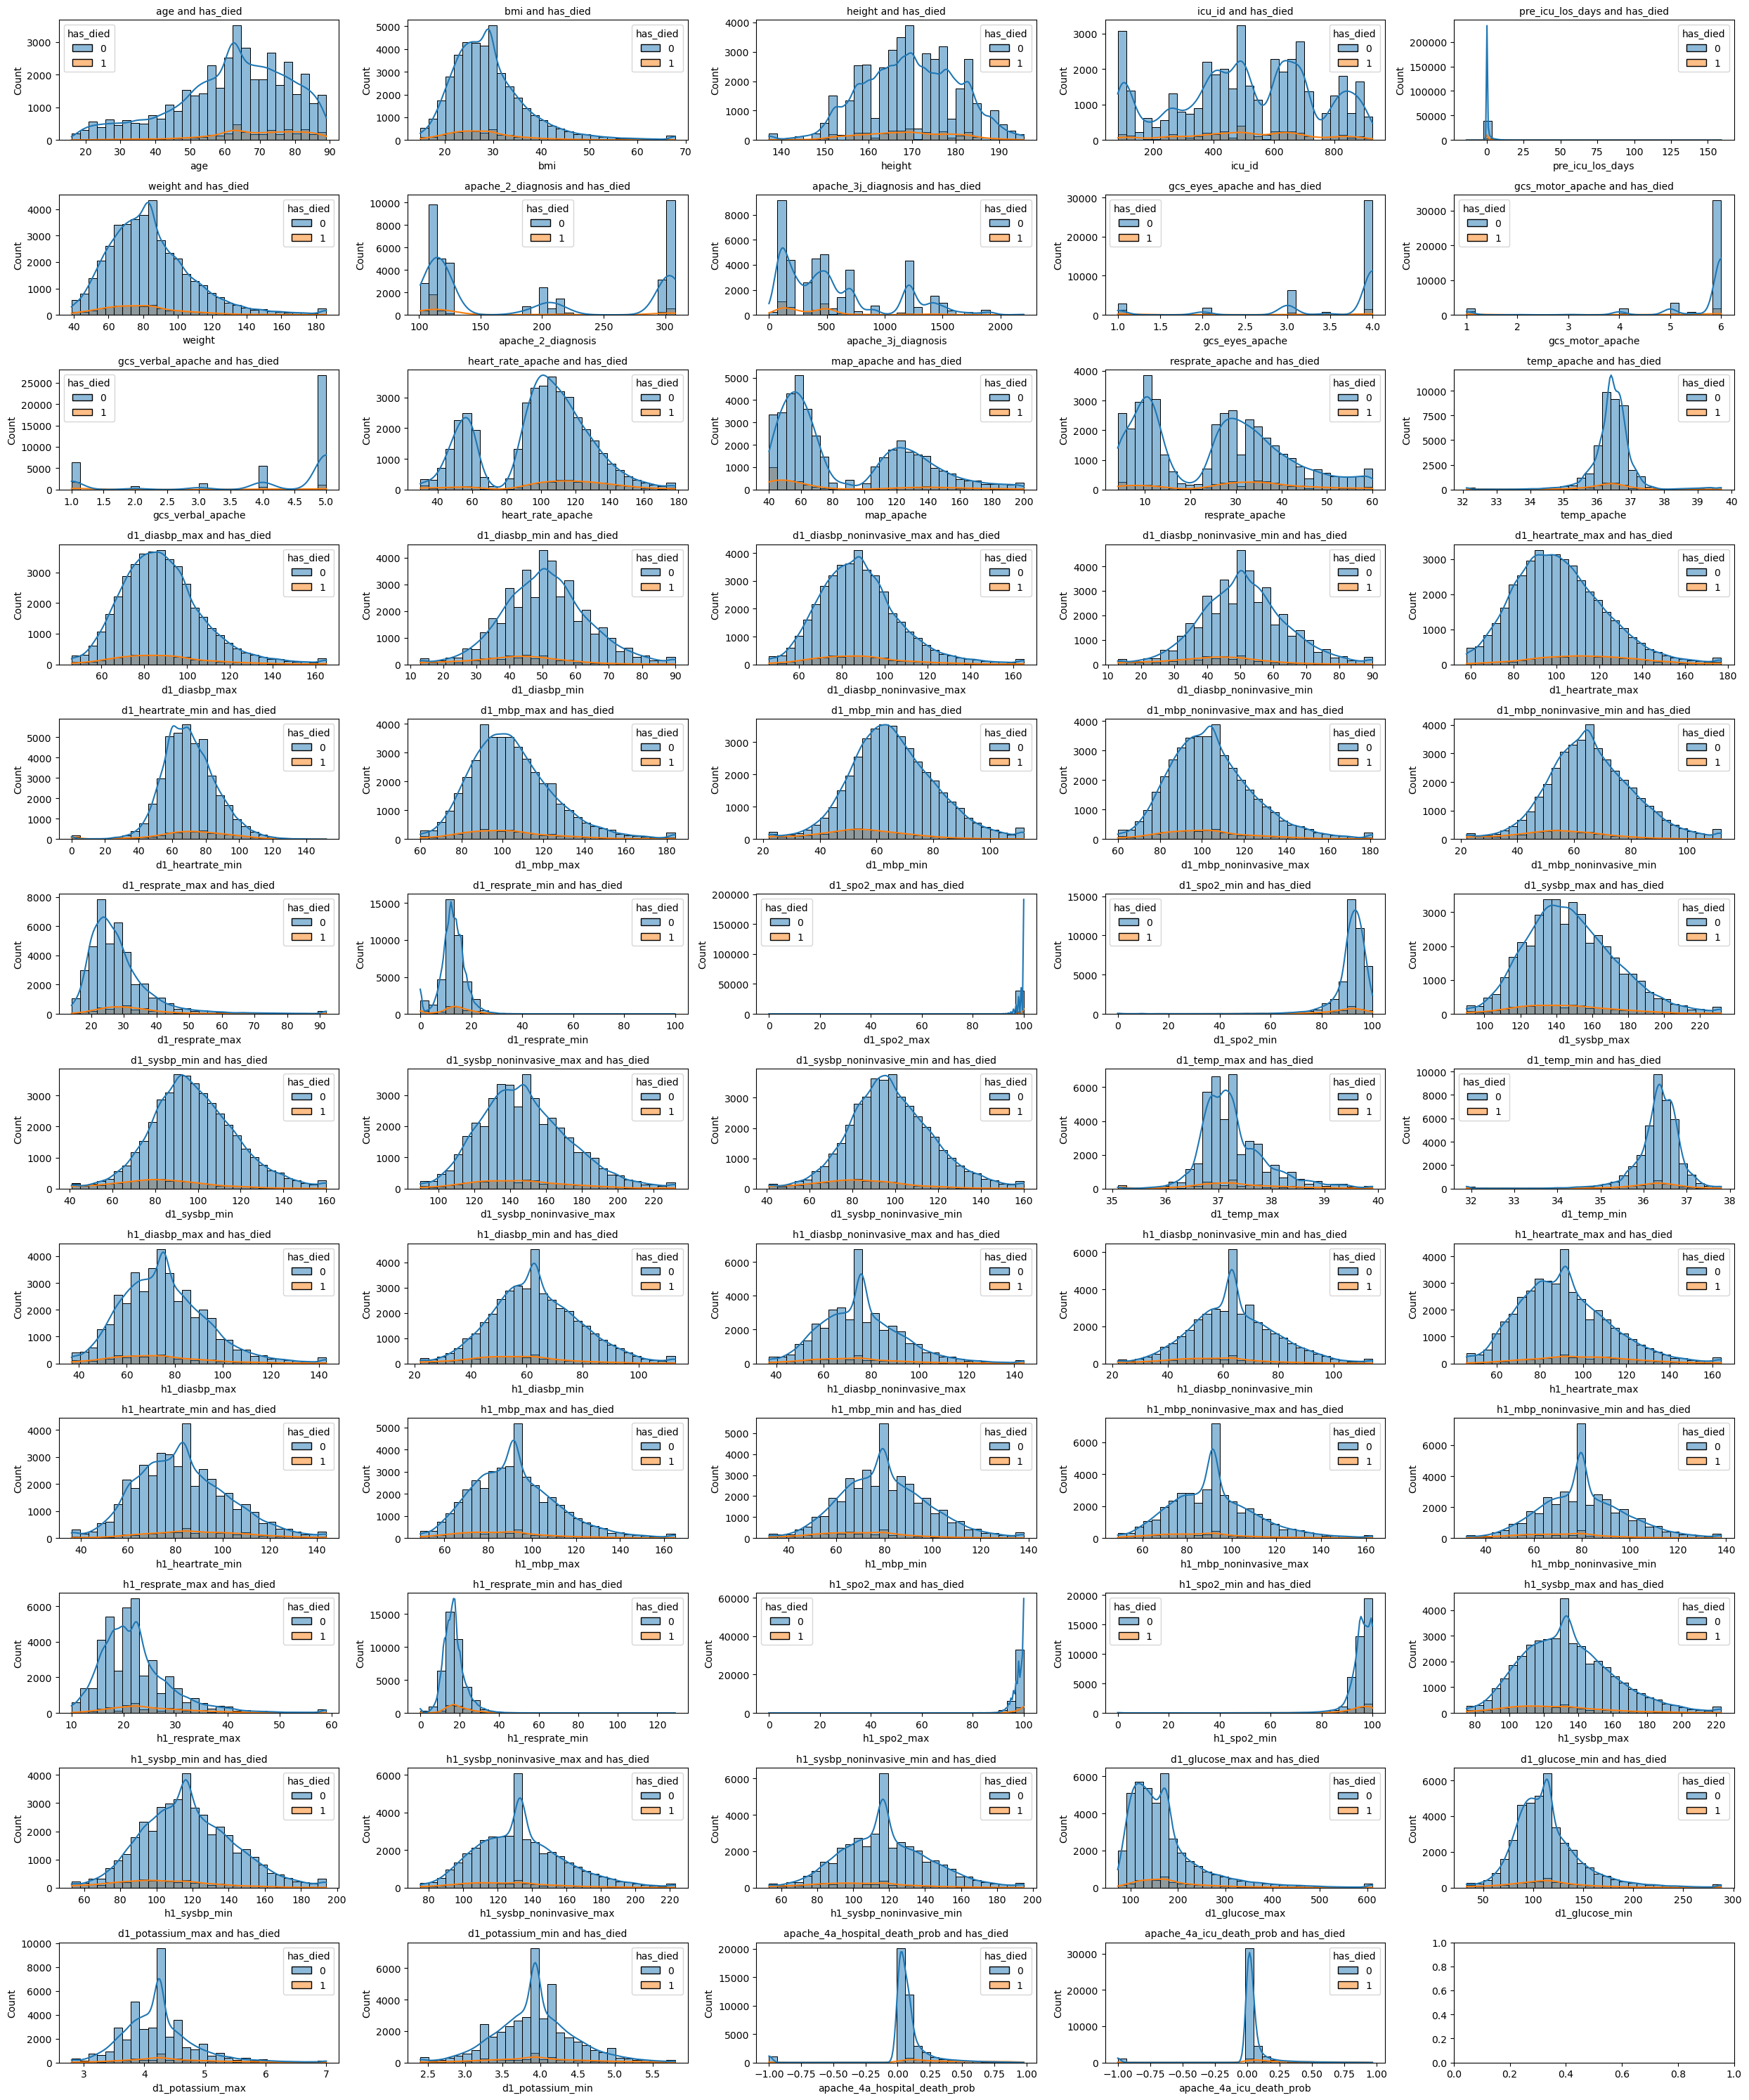

In [33]:
fig, axes = plt.subplots(12, 5, figsize=(25, 30))
axes = axes.flatten()  # 將多維的 axes 陣列展平，方便迭代

# 繪製每個特徵的分布圖
for i, col in enumerate(numeric_cols):
    sns.histplot(data=train_X, x=col, hue=train_y['has_died'], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'{col} and has_died', fontsize=10)
    axes[i].set_xlabel(col)  # 設置 x 軸標籤
    axes[i].set_ylabel("Count")  # 設置 y 軸標籤

plt.tight_layout()
plt.show()

### **類別型欄位與目標變數 Count plots**

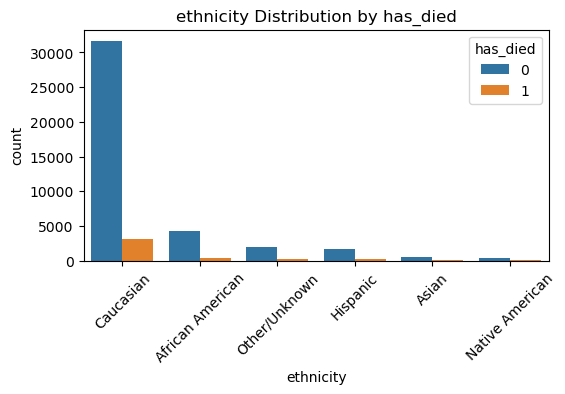

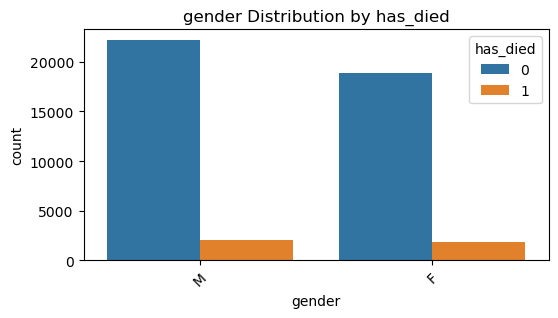

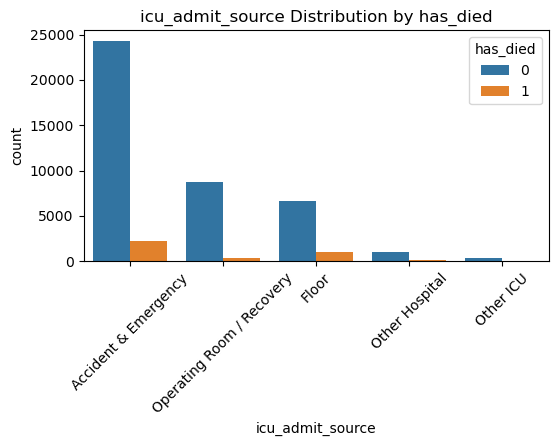

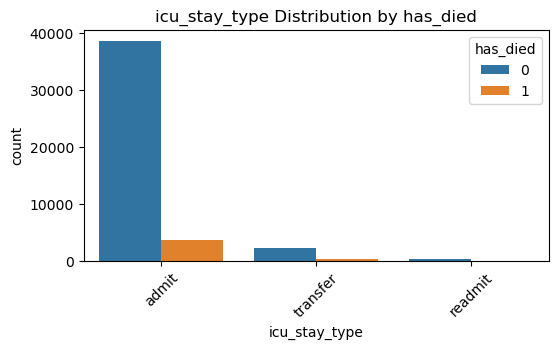

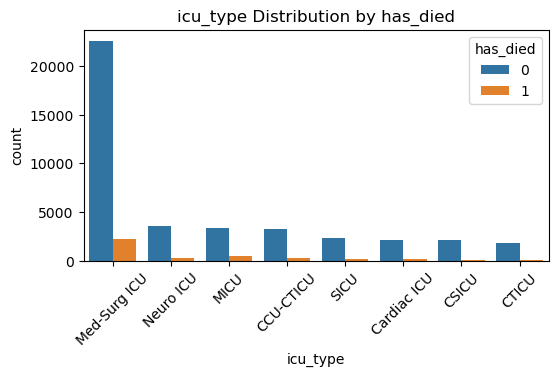

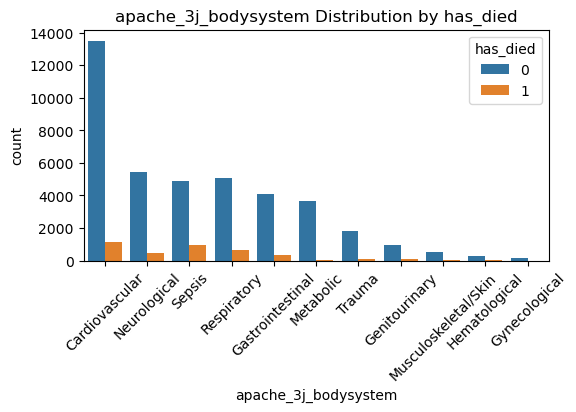

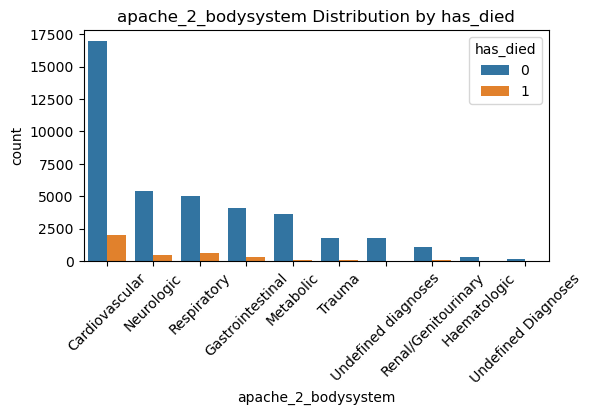

In [26]:
for col in categorical_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=train_X.join(train_y), x=col, hue='has_died', order=train_X[col].value_counts().index)
    plt.title(f'{col} Distribution by has_died')
    plt.xticks(rotation=45)
    plt.show()


### **數值型欄位與目標變數 Box plots**

/var/folders/hc/qn4p7nv158db9pdkwfkxrzm40000gp/T/ipykernel_67327/3171213537.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/hc/qn4p7nv158db9pdkwfkxrzm40000gp/T/ipykernel_67327/3171213537.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/hc/qn4p7nv158db9pdkwfkxrzm40000gp/T/ipykernel_67327/3171213537.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/hc/qn4p7nv158db9pdkwfkxrzm40000gp/T/ipykernel_67327/3171213537.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

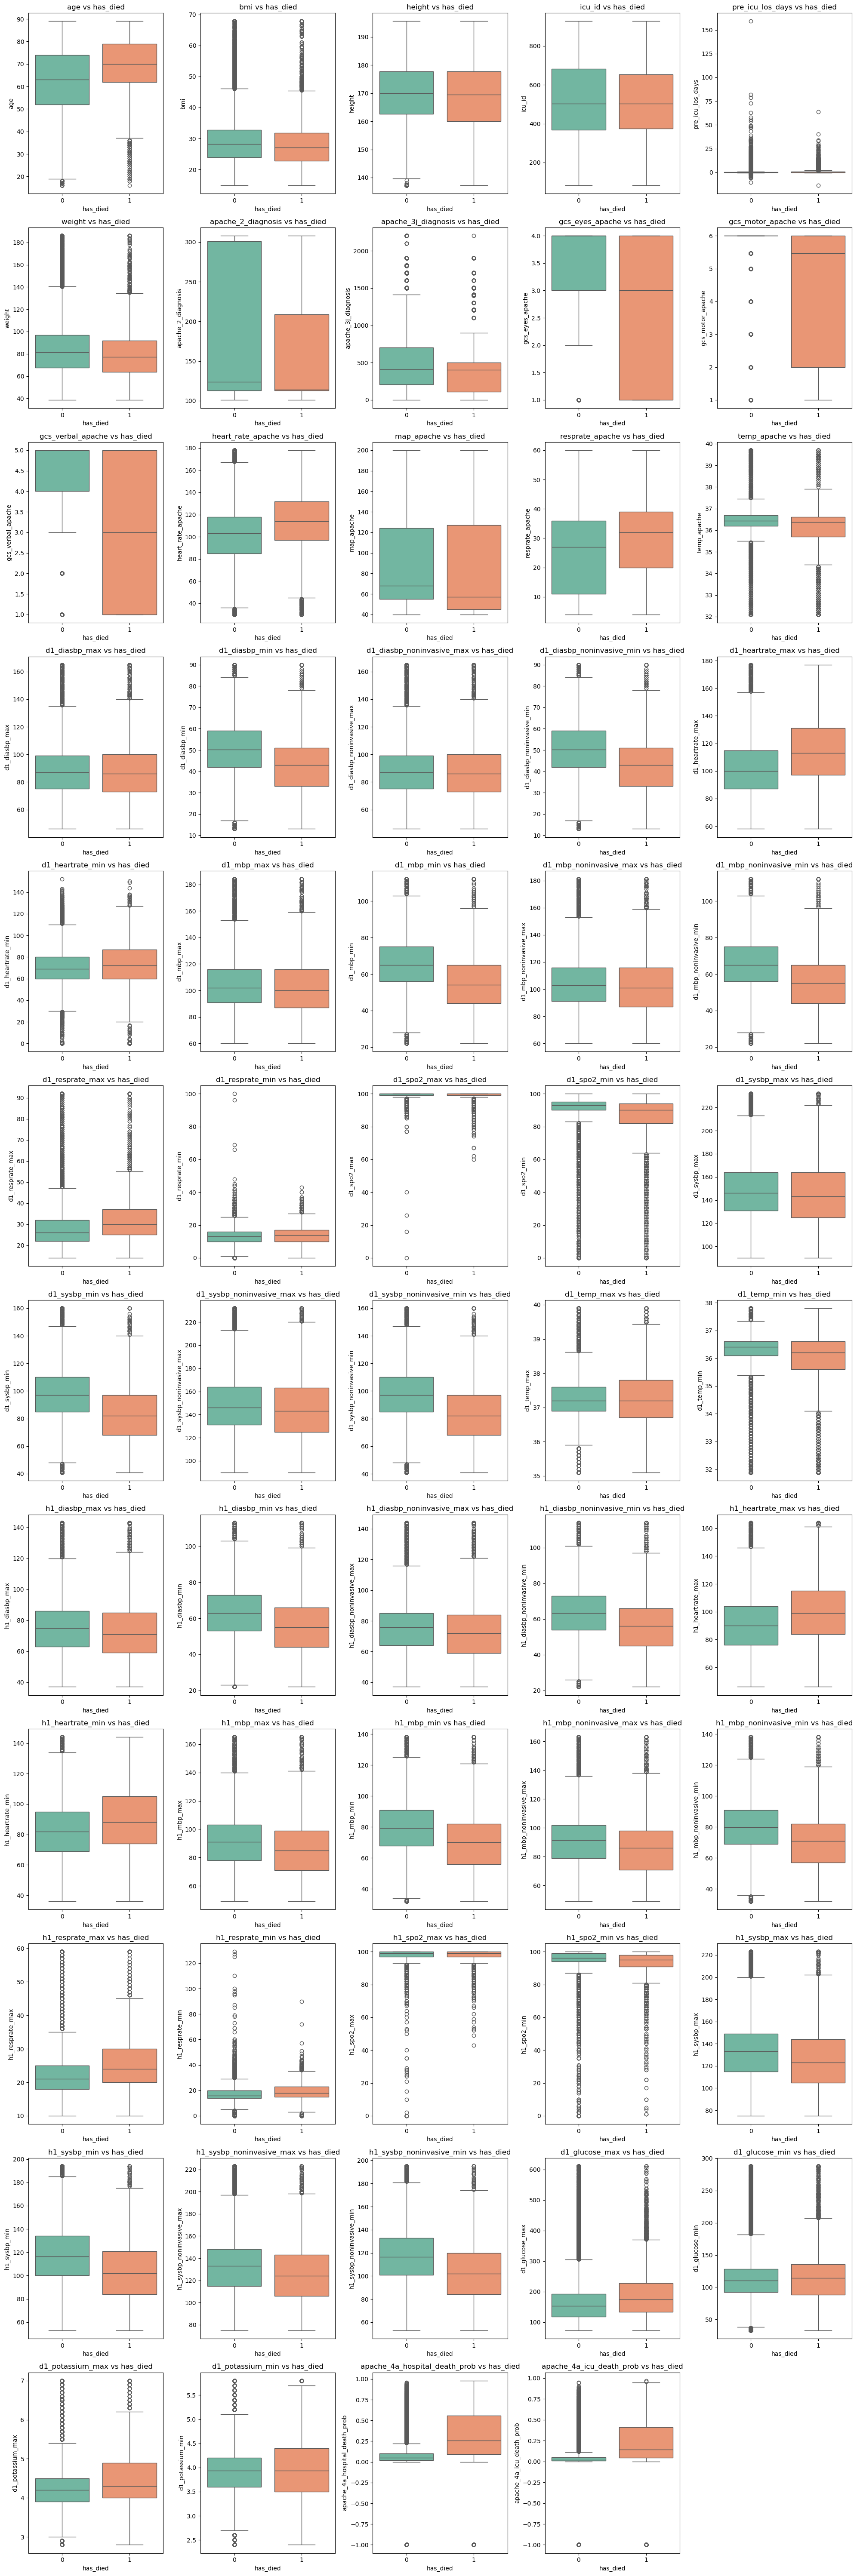

In [ ]:
num_cols = len(numeric_cols)
cols_per_row = 5  
num_rows = (num_cols + cols_per_row - 1) // cols_per_row  

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(20, num_rows * 5))
axes = axes.flatten()  

for i, col in enumerate(numeric_cols):
    sns.boxplot(
        data=train_X.join(train_y), 
        x='has_died', 
        y=col, 
        ax=axes[i],
        palette="Set2"
    )
    axes[i].set_title(f'{col} vs has_died', fontsize=12)
    axes[i].set_xlabel('has_died')  
    axes[i].set_ylabel(col)  

for ax in axes[num_cols:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## **Data Imputation 缺失值填補**

In [8]:
imputer_numeric = SimpleImputer(strategy='mean')
train_X[numeric_cols] = imputer_numeric.fit_transform(train_X[numeric_cols])
test_X[numeric_cols] = imputer_numeric.transform(test_X[numeric_cols])

imputer_categorical = SimpleImputer(strategy='most_frequent')
train_X[categorical_cols] = imputer_categorical.fit_transform(train_X[categorical_cols])
test_X[categorical_cols] = imputer_categorical.transform(test_X[categorical_cols])

imputer_binary = SimpleImputer(strategy='most_frequent')
train_X[binary_cols] = imputer_binary.fit_transform(train_X[binary_cols])
test_X[binary_cols] = imputer_binary.transform(test_X[binary_cols])

print("Missing values in train_X:", train_X.isnull().sum().sum())
print("Missing values in test_X:", test_X.isnull().sum().sum())

Missing values in train_X: 0
Missing values in test_X: 0


### **Encoding 時發現 apache_2_bodysystem 裡面的 undefined diagnoses 和 undefined Diagnoses 被視為「不同值」**
-> 需進行統一處理

In [9]:
# 清洗類別型欄位值
train_X['apache_2_bodysystem'] = train_X['apache_2_bodysystem'].str.strip().str.lower()
test_X['apache_2_bodysystem'] = test_X['apache_2_bodysystem'].str.strip().str.lower()

train_X['apache_3j_bodysystem'] = train_X['apache_3j_bodysystem'].str.strip().str.lower()
test_X['apache_3j_bodysystem'] = test_X['apache_3j_bodysystem'].str.strip().str.lower()

print("Unique values in train_X['apache_2_bodysystem']:", train_X['apache_2_bodysystem'].unique())
print("Unique values in test_X['apache_2_bodysystem']:", test_X['apache_2_bodysystem'].unique())


Unique values in train_X['apache_2_bodysystem']: ['trauma' 'undefined diagnoses' 'neurologic' 'gastrointestinal'
 'cardiovascular' 'respiratory' 'renal/genitourinary' 'metabolic'
 'haematologic']
Unique values in test_X['apache_2_bodysystem']: ['undefined diagnoses' 'cardiovascular' 'trauma' 'metabolic' 'respiratory'
 'gastrointestinal' 'neurologic' 'renal/genitourinary' 'haematologic']


### **One Hot encoding**

In [10]:
train_X = pd.get_dummies(train_X, columns=categorical_cols, drop_first=True)
test_X = pd.get_dummies(test_X, columns=categorical_cols, drop_first=True)

test_X = test_X.reindex(columns=train_X.columns, fill_value=0)

train_X = train_X.astype(int)
test_X = test_X.astype(int)

# 確認資料型別
test_X.head()

patient_id  age  bmi  elective_surgery  height  icu_id  pre_icu_los_days  \
0         326   80   28                 1     175     362                 0   
1       43497   56   38                 0     175     619                 0   
2      117587   87   14                 0     168     594                 0   
3       22299   76   35                 0     152     408                 0   
4       65485   20   34                 0     150     347                 0   

   weight  apache_2_diagnosis  apache_3j_diagnosis  ...  \
0      86                 308                 1903  ...   
1     117                 112                  107  ...   
2      39                 119                  601  ...   
3      83                 302                  109  ...   
4      78                 122                  703  ...   

   apache_3j_bodysystem_sepsis  apache_3j_bodysystem_trauma  \
0                            0                            0   
1                            0                            0   
2                            0                            1   
3                            0                            0   
4                            0                            0   

   apache_2_bodysystem_gastrointestinal  apache_2_bodysystem_haematologic  \
0                                     0                                 0   
1                                     0                                 0   
2                                     0                                 0   
3                                     0                                 0   
4                                     0                                 0   

   apache_2_bodysystem_metabolic  apache_2_bodysystem_neurologic  \
0                              0                               0   
1                              0                               0   
2                              0                               0   
3                              0                               0   
4                              1                               0   

   apache_2_bodysystem_renal/genitourinary  apache_2_bodysystem_respiratory  \
0                                        0                                0   
1                                        0                                0   
2                                        0                                0   
3                                        0                                0   
4                                        0                                0   

   apache_2_bodysystem_trauma  apache_2_bodysystem_undefined diagnoses  
0                           0                                        1  
1                           0                                        0  
2                           1                                        0  
3                           0                                        0  
4                           0                                        0  

[5 rows x 111 columns]

## **數值型欄位資料縮放 - Standard Scaler**

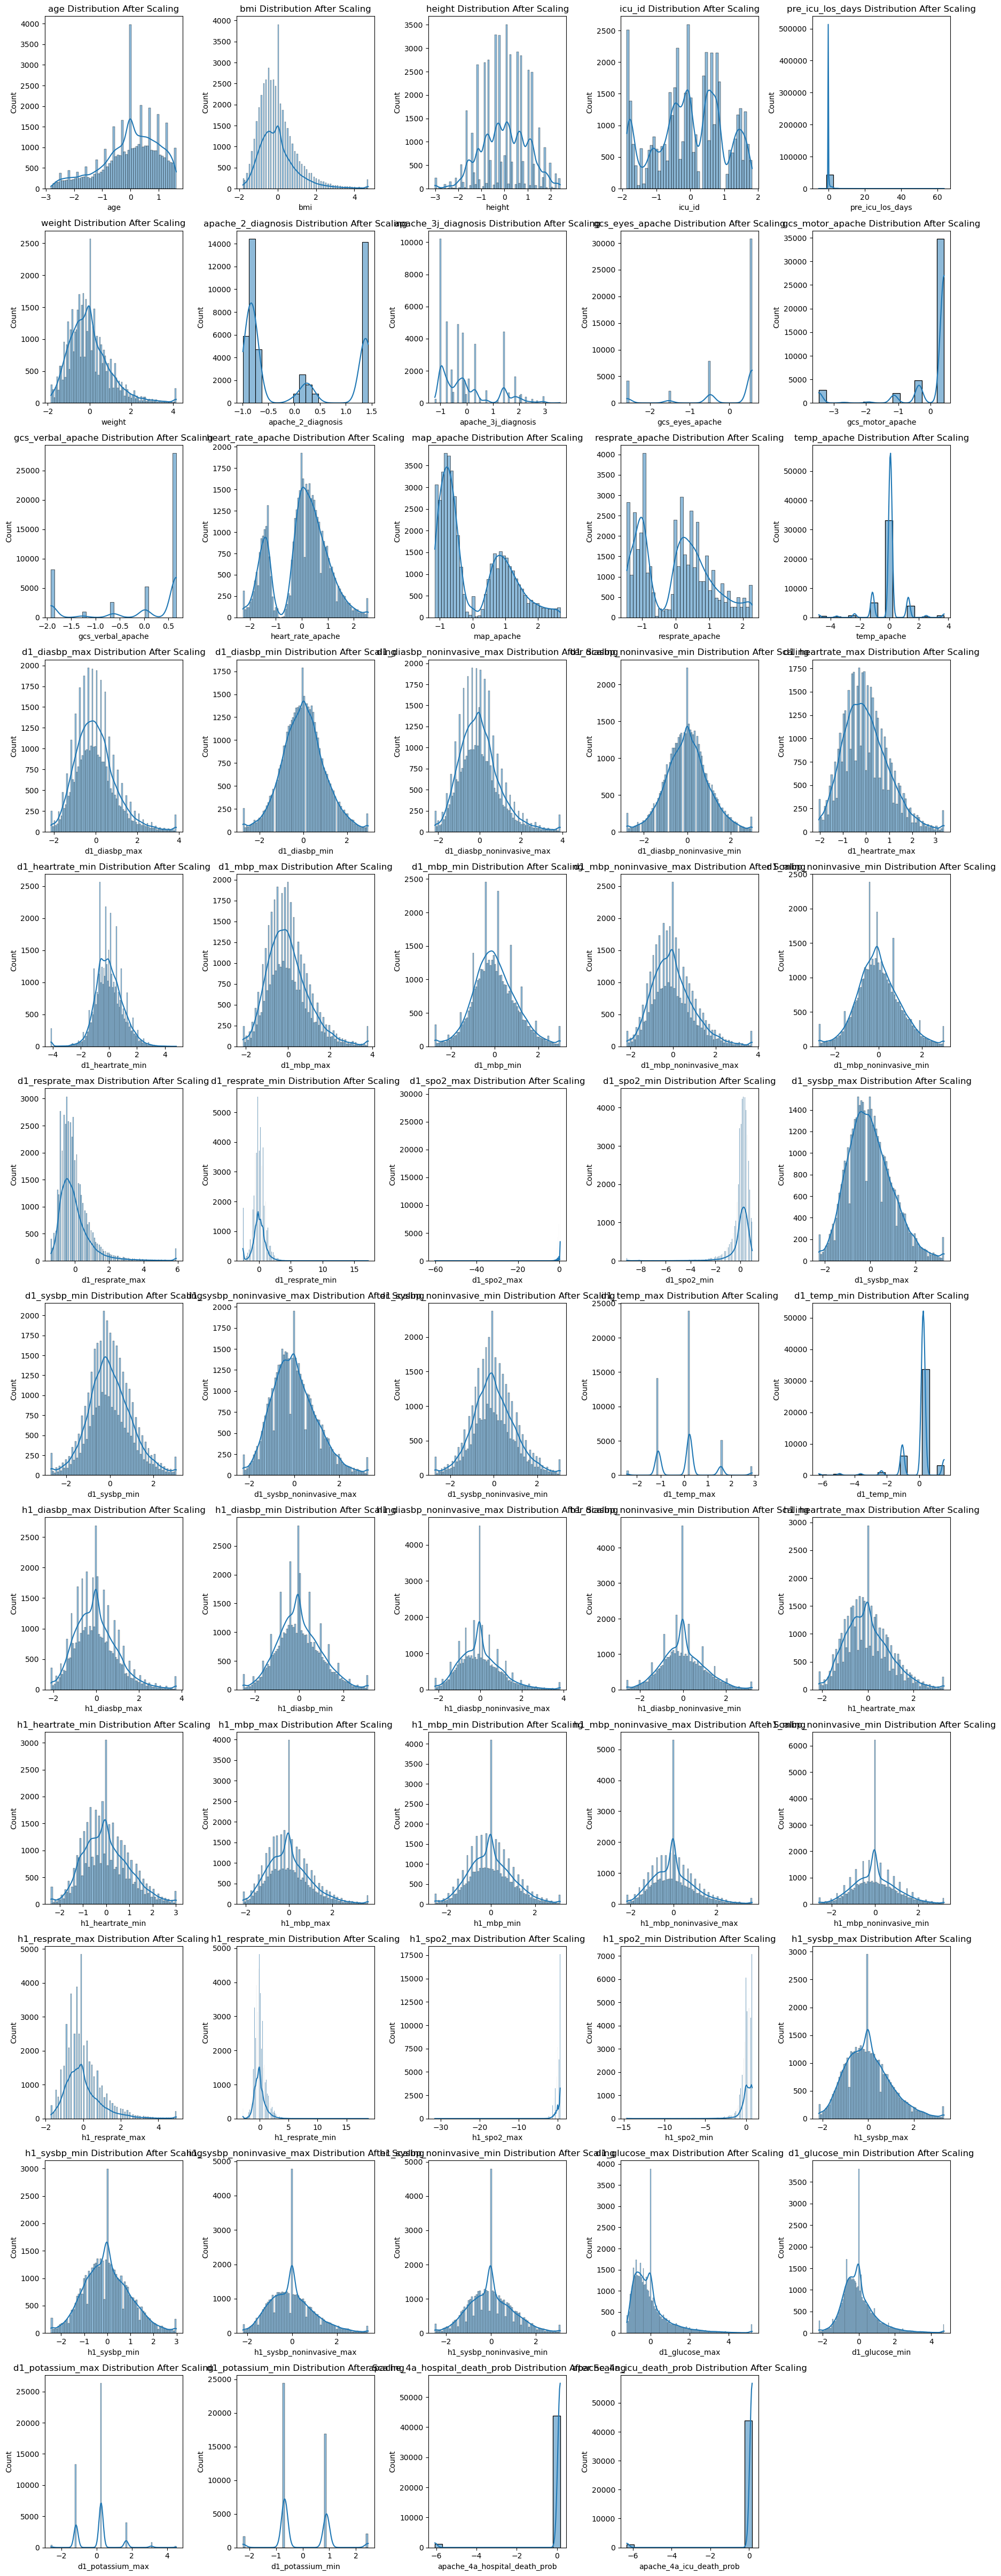

In [11]:
scaler = StandardScaler()
train_X[numeric_cols] = scaler.fit_transform(train_X[numeric_cols])
test_X[numeric_cols] = scaler.transform(test_X[numeric_cols])

# Plot each feature after scaling to ensure
plt.figure(figsize=(18, 4 * (len(numeric_cols) // 3 + 1)))
for idx, feature in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols) // 3 + 1, 5, idx)
    sns.histplot(train_X[feature], kde=True)
    plt.title(f'{feature} Distribution After Scaling')
plt.tight_layout()
plt.show()

## **目標變數 SMOTE 處理**

In [12]:

smote = SMOTE(sampling_strategy='auto', random_state=42)
train_X_resampled, train_y_resampled = smote.fit_resample(train_X, train_y)

print("After resampling:", Counter(train_y_resampled['has_died']))

After resampling: Counter({0: 41061, 1: 41061})


## **Model Building**

### **Model 1 - Gradient Boost**

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)


# 初始化 Gradient Boosting 模型
best_gb = GradientBoostingClassifier(n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    random_state=42)

# 計算 AUROC 和 macro F1，使用 K-Fold CV
auroc_scores_gb = cross_val_score(best_gb, train_X_resampled, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_gb = cross_val_score(best_gb, train_X_resampled, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

# 顯示 AUROC 和 macro F1 的結果
print("Cross-validation AUROC scores (Gradient Boosting):", auroc_scores_gb)
print("Mean AUROC score (Gradient Boosting):", auroc_scores_gb.mean())
print("Cross-validation macro F1 scores (Gradient Boosting):", macro_f1_scores_gb)
print("Mean macro F1 score (Gradient Boosting):", macro_f1_scores_gb.mean())

# 訓練模型
best_gb.fit(train_X_resampled, train_y_resampled)

original_patient_ids = test_X['patient_id']

# 確保 test_X 的欄位與 train_X_resampled 一致
test_X = test_X.reindex(columns=train_X_resampled.columns, fill_value=0)

# 使用訓練好的模型 `best_gb` 來預測 `has_died`
predictions = best_gb.predict(test_X)

# 建立符合格式的提交檔案，保證 patient_id 與原始順序一致
submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

# 將結果存成 .csv 文件以符合 Kaggle 格式
submission.to_csv('gb_submission_3.csv', index=False)

# 顯示檔案的總行數確認
row_count = len(submission)
print(f"Number of rows in 'gb_submission_3.csv': {row_count}")
print("Submission file saved as 'gb_submission_3.csv'")

/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

KeyboardInterrupt: 

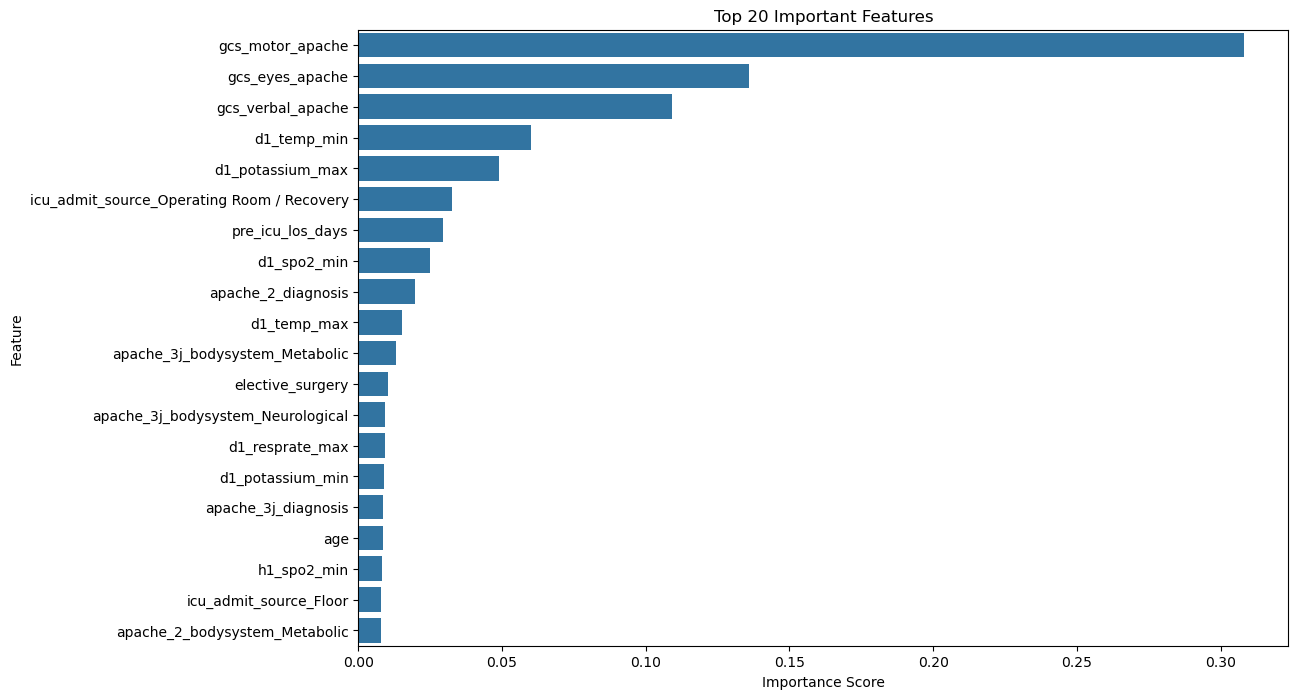

                                        Feature  Importance
13                             gcs_motor_apache    0.308196
12                              gcs_eyes_apache    0.136022
15                            gcs_verbal_apache    0.109201
41                                  d1_temp_min    0.059953
62                             d1_potassium_max    0.048863
81   icu_admit_source_Operating Room / Recovery    0.032594
6                              pre_icu_los_days    0.029535
35                                  d1_spo2_min    0.025061
8                            apache_2_diagnosis    0.019753
40                                  d1_temp_max    0.015051
97               apache_3j_bodysystem_Metabolic    0.013137
3                              elective_surgery    0.010132
99            apache_3j_bodysystem_Neurological    0.009231
32                              d1_resprate_max    0.009172
63                             d1_potassium_min    0.008990
9                           apache_3j_di

In [14]:
# Get feature importances from the trained Gradient Boosting model
feature_importances = best_gb.feature_importances_

# Create a DataFrame to hold feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': train_X_resampled.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance scores in descending order and get the top 20 features
top_20_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features)
plt.title('Top 20 Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Display the top 20 important features
print(top_20_features)

### **Model 2 - XGBoost**

In [ ]:
from xgboost import XGBClassifier

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

auroc_scores_xgb = cross_val_score(best_xgb, train_X_resampled, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_xgb = cross_val_score(best_xgb, train_X_resampled, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (XGBoost):", auroc_scores_xgb)
print("Mean AUROC score (XGBoost):", auroc_scores_xgb.mean())
print("Cross-validation macro F1 scores (XGBoost):", macro_f1_scores_xgb)
print("Mean macro F1 score (XGBoost):", macro_f1_scores_xgb.mean())

best_xgb.fit(train_X_resampled, train_y_resampled)

test_X = test_X.reindex(columns=train_X_resampled.columns, fill_value=0)

original_patient_ids = test_X['patient_id']

predictions = best_xgb.predict(test_X)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('xgb_submission.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'xgb_submission.csv': {row_count}")
print("Submission file saved as 'xgb_submission.csv'")


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:14:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:14:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:14:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:14:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

Cross-validation AUROC scores (XGBoost): [0.9869425  0.98891336 0.98831121 0.98853529 0.98805885]
Mean AUROC score (XGBoost): 0.9881522415402735
Cross-validation macro F1 scores (XGBoost): [0.95275095 0.95724374 0.95359569 0.95323913 0.95248493]
Mean macro F1 score (XGBoost): 0.9538628887902544


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:15:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Number of rows in 'xgb_submission.csv': 19260
Submission file saved as 'xgb_submission.csv'


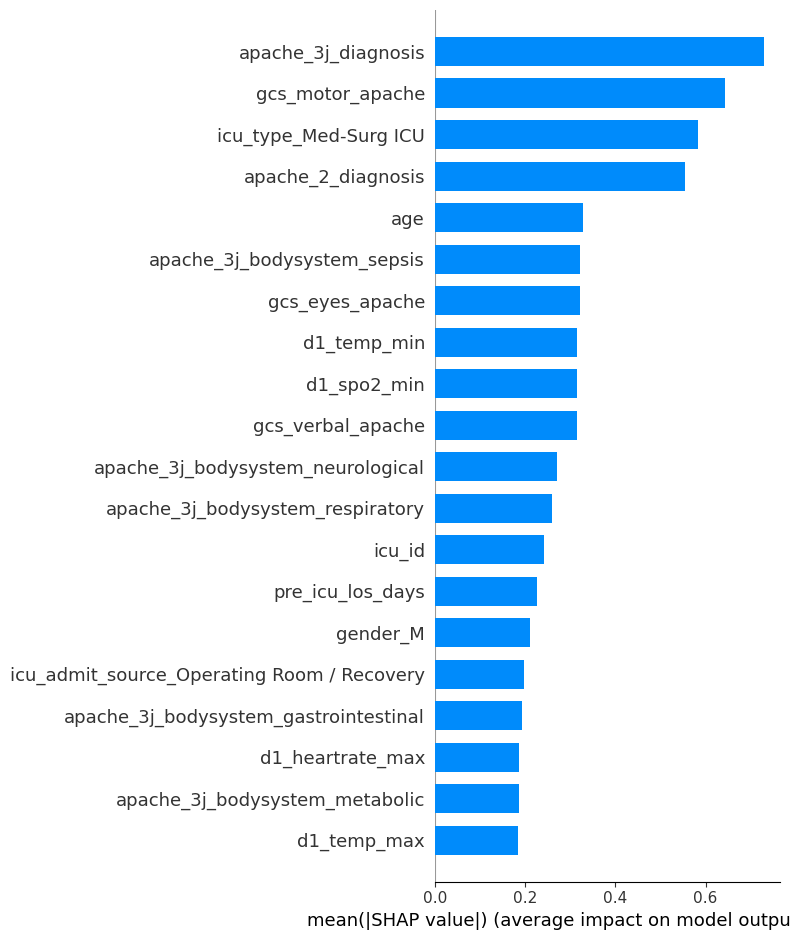

In [52]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(train_X_resampled)

# Summary plot for feature importance
shap.summary_plot(shap_values, train_X_resampled, plot_type="bar")

# Detailed SHAP plot for individual predictions (e.g., first patient in test set)
shap.force_plot(explainer.expected_value, shap_values[0], train_X_resampled.iloc[0])


In [28]:
# Select the top 30 features based on importance
top_30_xgb_features = top_xgb_features.head(30)

print(top_30_xgb_features)

                                        Feature  Importance
13                             gcs_motor_apache    0.130006
12                              gcs_eyes_apache    0.106447
81   icu_admit_source_Operating Room / Recovery    0.088312
97               apache_3j_bodysystem_Metabolic    0.057952
15                            gcs_verbal_apache    0.051898
41                                  d1_temp_min    0.039706
10                        apache_post_operative    0.035726
99            apache_3j_bodysystem_Neurological    0.031354
3                              elective_surgery    0.030956
62                             d1_potassium_max    0.029901
88                         icu_type_Cardiac ICU    0.025076
40                                  d1_temp_max    0.023725
100            apache_3j_bodysystem_Respiratory    0.018919
63                             d1_potassium_min    0.018710
80                       icu_admit_source_Floor    0.018256
6                              pre_icu_l

### **Model 3 - Random Forest**

In [18]:
from sklearn.ensemble import RandomForestClassifier

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_rf = RandomForestClassifier(
    n_estimators=500,  
    max_depth=10,  
    min_samples_split=5,  
    min_samples_leaf=2,  
    random_state=42,
    n_jobs=-1  
)

auroc_scores_rf = cross_val_score(best_rf, train_X_resampled, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_rf = cross_val_score(best_rf, train_X_resampled, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (Random Forest):", auroc_scores_rf)
print("Mean AUROC score (Random Forest):", auroc_scores_rf.mean())
print("Cross-validation macro F1 scores (Random Forest):", macro_f1_scores_rf)
print("Mean macro F1 score (Random Forest):", macro_f1_scores_rf.mean())

best_rf.fit(train_X_resampled, train_y_resampled)

test_X = test_X.reindex(columns=train_X_resampled.columns, fill_value=0)

original_patient_ids = test_X['patient_id']

predictions = best_rf.predict(test_X)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('rf_submission_new.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'rf_submission_new.csv': {row_count}")
print("Submission file saved as 'rf_submission_new.csv'")


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

Cross-validation AUROC scores (Random Forest): [0.97782733 0.98083129 0.98028904 0.97879728 0.97937065]
Mean AUROC score (Random Forest): 0.9794231183657175
Cross-validation macro F1 scores (Random Forest): [0.92486978 0.93034199 0.92839593 0.92632085 0.92699229]
Mean macro F1 score (Random Forest): 0.9273841680685999


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Number of rows in 'rf_submission_new.csv': 19260
Submission file saved as 'rf_submission_new.csv'


### **SHAP value of RF features**

Note: you may need to restart the kernel to use updated packages.


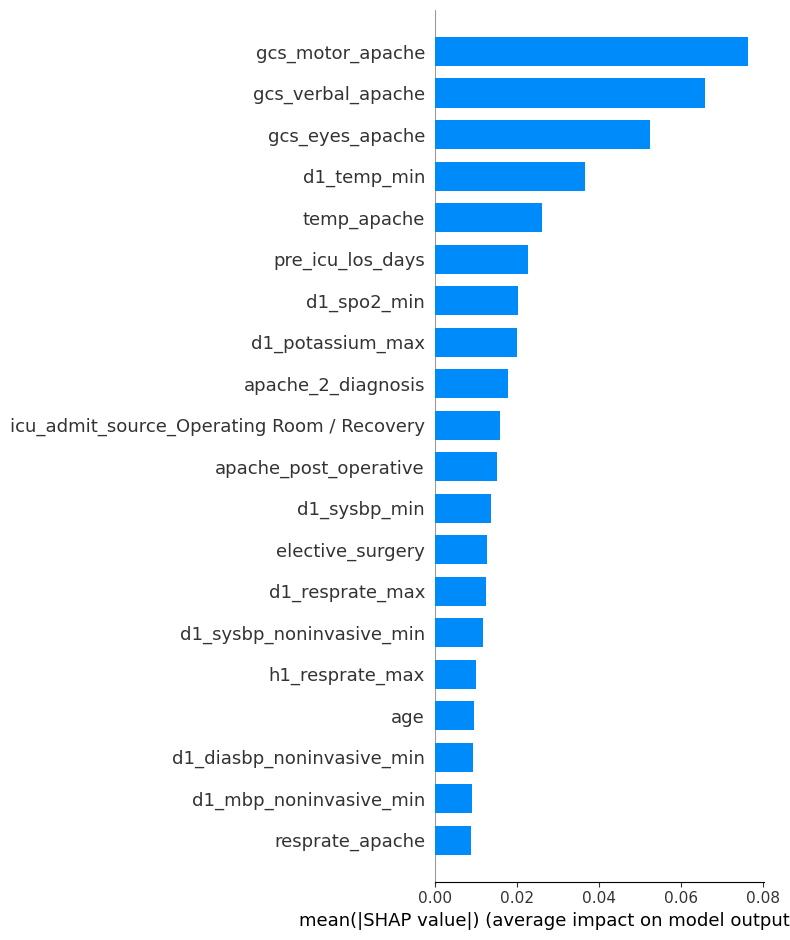

In [19]:
%pip install shap

import shap
import matplotlib.pyplot as plt


# Initialize SHAP Explainer
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(train_X_resampled)

# Summary plot for feature importance
shap.summary_plot(shap_values[1], train_X_resampled, plot_type="bar")

# Detailed SHAP plot for individual predictions (e.g., first patient in test set)
shap.force_plot(explainer.expected_value[1], shap_values[1][0], train_X_resampled.iloc[0])


### **feature importances 找出 XGB RF 重要 features -> 移除不重要特徵試試看**

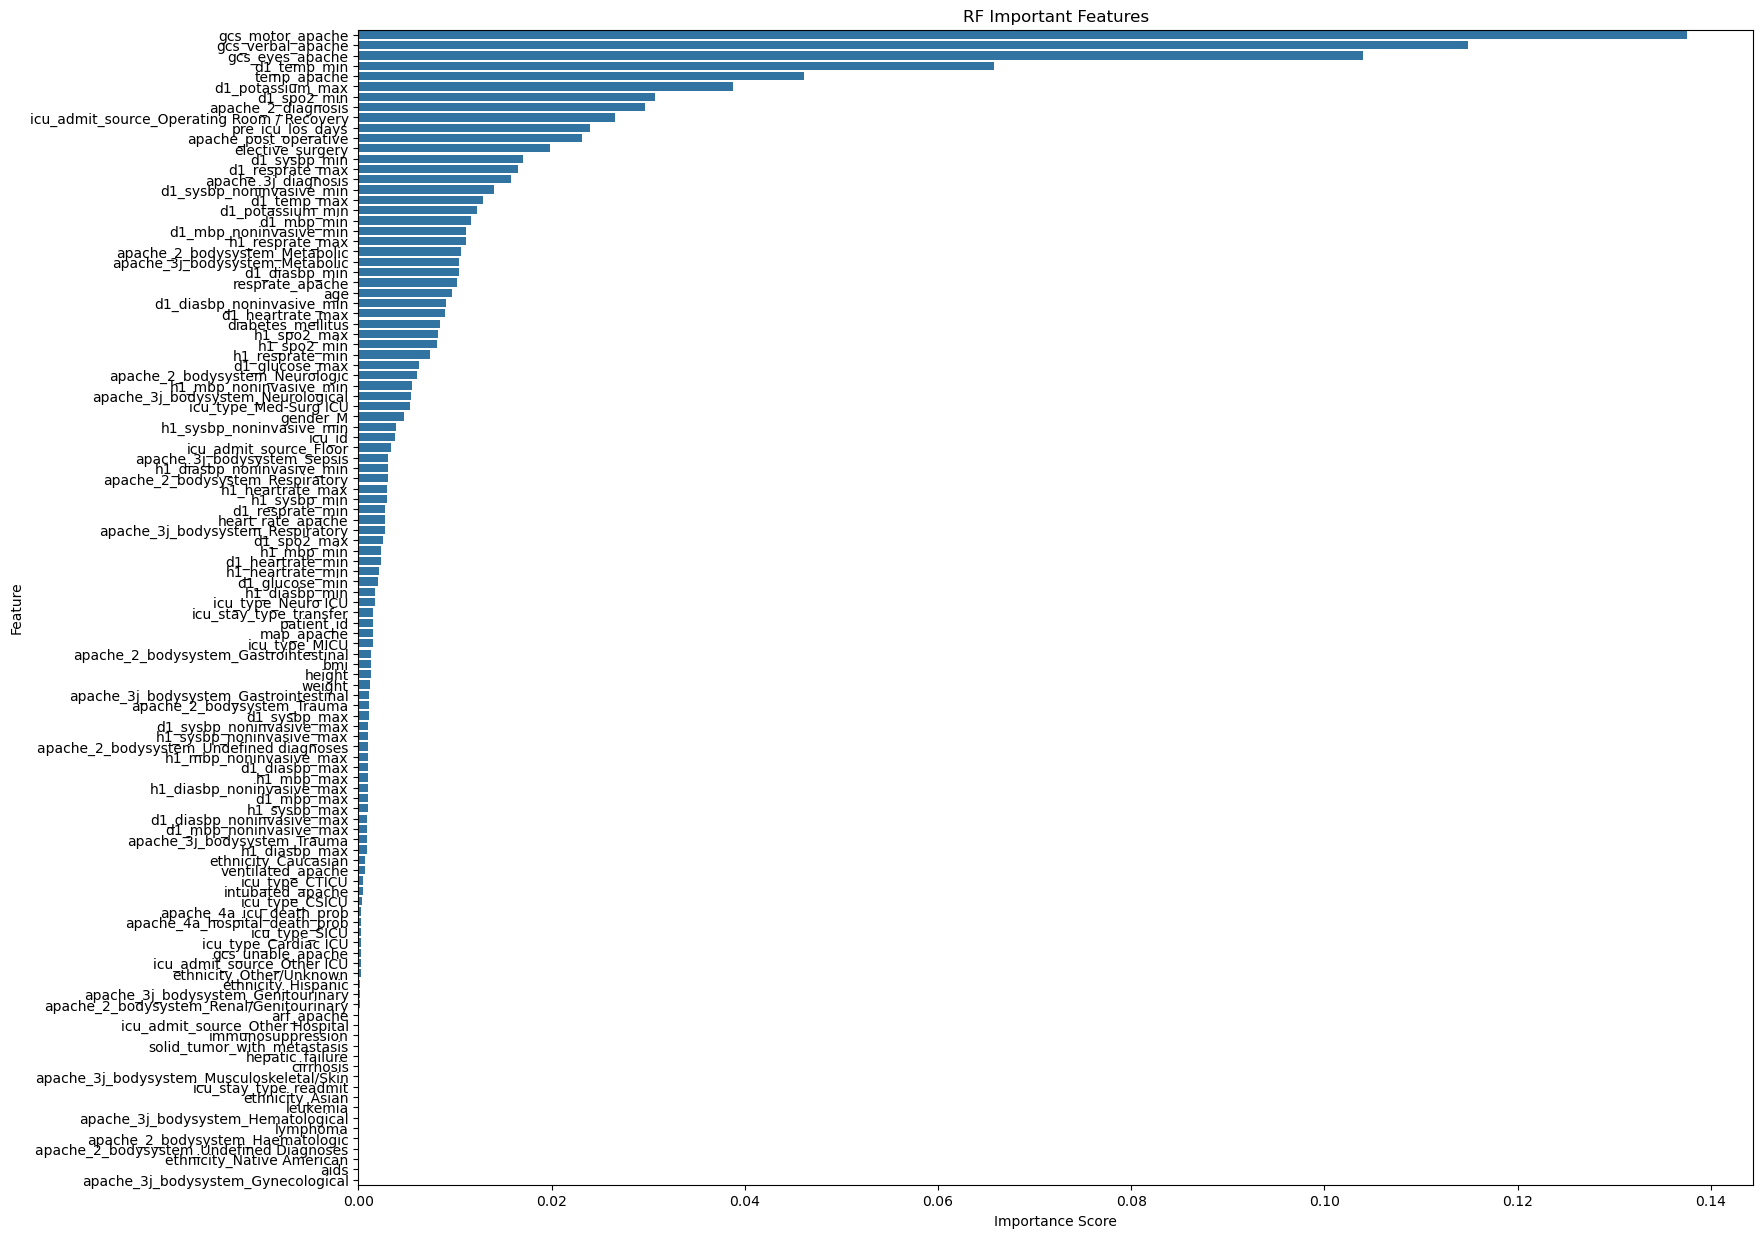

                                     Feature    Importance
13                          gcs_motor_apache  1.375279e-01
15                         gcs_verbal_apache  1.149105e-01
12                           gcs_eyes_apache  1.040093e-01
41                               d1_temp_min  6.574308e-02
20                               temp_apache  4.613292e-02
..                                       ...           ...
104         apache_2_bodysystem_Haematologic  8.748118e-06
110  apache_2_bodysystem_Undefined Diagnoses  4.372258e-06
77                 ethnicity_Native American  3.224884e-06
66                                      aids  2.293071e-07
95        apache_3j_bodysystem_Gynecological  0.000000e+00

[112 rows x 2 columns]


In [ ]:
feature_importances_rf = best_rf.feature_importances_

# Create a DataFrame to hold feature names and their importance scores
feature_importance_df_rf = pd.DataFrame({
    'Feature': train_X_resampled.columns,
    'Importance': feature_importances_rf
})

# Sort the DataFrame by importance scores in descending order and get the top 20 features
top_rf_features = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

# Plot the top 20 important features
plt.figure(figsize=(18, 15))
sns.barplot(x='Importance', y='Feature', data=top_rf_features)
plt.title('RF Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

print(top_rf_features)

### **移除 RF 不重要特徵**：  
1. apache_3j_bodysystem_Gynecological  

In [15]:
features_to_remove = ['apache_3j_bodysystem_Gynecological']

train_X_resampled_removed = train_X_resampled.drop(columns=features_to_remove, errors='ignore').copy()
test_X_removed = test_X.drop(columns=features_to_remove, errors='ignore').copy()

# 確認移除後的特徵

train_X_resampled_removed.columns


Index(['patient_id', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id',
       'pre_icu_los_days', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis',
       ...
       'apache_3j_bodysystem_sepsis', 'apache_3j_bodysystem_trauma',
       'apache_2_bodysystem_gastrointestinal',
       'apache_2_bodysystem_haematologic', 'apache_2_bodysystem_metabolic',
       'apache_2_bodysystem_neurologic',
       'apache_2_bodysystem_renal/genitourinary',
       'apache_2_bodysystem_respiratory', 'apache_2_bodysystem_trauma',
       'apache_2_bodysystem_undefined diagnoses'],
      dtype='object', length=111)

### **XGBoost - 移除不重要特徵版本**

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_xgb_2 = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

auroc_scores_xgb = cross_val_score(best_xgb_2, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_xgb = cross_val_score(best_xgb_2, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (XGBoost):", auroc_scores_xgb)
print("Mean AUROC score (XGBoost):", auroc_scores_xgb.mean())
print("Cross-validation macro F1 scores (XGBoost):", macro_f1_scores_xgb)
print("Mean macro F1 score (XGBoost):", macro_f1_scores_xgb.mean())

best_xgb_2.fit(train_X_resampled_removed, train_y_resampled)

test_X_removed = test_X.reindex(columns=train_X_resampled_removed.columns, fill_value=0)

original_patient_ids = test_X_removed['patient_id']

predictions = best_xgb_2.predict(test_X_removed)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('xgb_submission_2.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'xgb_submission_2.csv': {row_count}")
print("Submission file saved as 'xgb_submission_2.csv'")

/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [10:44:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [10:44:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [10:44:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [10:44:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

Cross-validation AUROC scores (XGBoost): [0.98875079 0.98943377 0.98922588 0.98932583 0.98949473]
Mean AUROC score (XGBoost): 0.989246199355275
Cross-validation macro F1 scores (XGBoost): [0.95827864 0.96227943 0.96021447 0.96084339 0.961786  ]
Mean macro F1 score (XGBoost): 0.9606803859178024


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [10:45:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Number of rows in 'xgb_submission_2.csv': 19260
Submission file saved as 'xgb_submission_2.csv'


### **Random Forest - 移除不重要特徵版本**

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_rf_2 = RandomForestClassifier(
    n_estimators=500,  
    max_depth=10,  
    min_samples_split=5,  
    min_samples_leaf=2,  
    random_state=42,
    n_jobs=-1  
)

auroc_scores_rf = cross_val_score(best_rf_2, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_rf = cross_val_score(best_rf_2, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (Random Forest):", auroc_scores_rf)
print("Mean AUROC score (Random Forest):", auroc_scores_rf.mean())
print("Cross-validation macro F1 scores (Random Forest):", macro_f1_scores_rf)
print("Mean macro F1 score (Random Forest):", macro_f1_scores_rf.mean())

best_rf_2.fit(train_X_resampled_removed, train_y_resampled)

test_X_removed = test_X.reindex(columns=train_X_resampled_removed.columns, fill_value=0)

original_patient_ids = test_X_removed['patient_id']

predictions = best_rf_2.predict(test_X_removed)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('rf_submission_new2.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'rf_submission_new2.csv': {row_count}")
print("Submission file saved as 'rf_submission_new2.csv'")


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

Cross-validation AUROC scores (Random Forest): [0.97801146 0.98120768 0.98025167 0.97908936 0.97956919]
Mean AUROC score (Random Forest): 0.9796258718996512
Cross-validation macro F1 scores (Random Forest): [0.92627007 0.93174125 0.9283946  0.9268094  0.92717559]
Mean macro F1 score (Random Forest): 0.9280781798642679


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Number of rows in 'rf_submission_new2.csv': 19260
Submission file saved as 'rf_submission_new2.csv'


### **Model 4 - Soft Voting - 所有特徵版本**
Kaggle -> 0.706

In [26]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report

kf = KFold(n_splits=5, shuffle=True, random_state=42)

estimator = []
estimator.append(('LogisticRegression', LogisticRegression(max_iter=200, random_state=42, solver='lbfgs')))
estimator.append(('RandomForest', RandomForestClassifier(n_estimators=500, random_state=42)))
estimator.append(('GradientBoosting', GradientBoostingClassifier(n_estimators=500, random_state=42)))
estimator.append(('AdaBoost', AdaBoostClassifier(n_estimators=100, random_state=42)))
estimator.append(('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)))

VC_soft = VotingClassifier(estimators=estimator, voting='soft', n_jobs=-1)

auroc_scores_vc = cross_val_score(VC_soft, train_X_resampled, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_vc = cross_val_score(VC_soft, train_X_resampled, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (Voting Classifier):", auroc_scores_vc)
print("Mean AUROC score (Voting Classifier):", auroc_scores_vc.mean())
print("Cross-validation macro F1 scores (Voting Classifier):", macro_f1_scores_vc)
print("Mean macro F1 score (Voting Classifier):", macro_f1_scores_vc.mean())

VC_soft.fit(train_X_resampled, train_y_resampled)

test_X = test_X.reindex(columns=train_X_resampled.columns, fill_value=0)

original_patient_ids = test_X['patient_id']

predictions = VC_soft.predict(test_X)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('vc_soft_submission.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'vc_soft_submission.csv': {row_count}")
print("Submission file saved as 'vc_soft_submission.csv'")


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y 

Cross-validation AUROC scores (Voting Classifier): [0.98812298 0.98950809 0.98903242 0.98864251 0.98894217]
Mean AUROC score (Voting Classifier): 0.988849633525111
Cross-validation macro F1 scores (Voting Classifier): [0.95658854 0.96168672 0.95840251 0.95737942 0.95888304]
Mean macro F1 score (Voting Classifier): 0.9585880479226295


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [11:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Number of rows in 'vc_soft_submission.csv': 19260
Submission file saved as 'vc_soft_submission.csv'


### **Soft Voting - Top 30 Features 版本** 
Kaggle -> 0.703

In [ ]:
# Use Top 30 features from RF
rf_feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selector.fit(train_X_resampled, train_y_resampled)


feature_importances = pd.Series(rf_feature_selector.feature_importances_, index=train_X_resampled.columns)
top_30_features = feature_importances.nlargest(30).index
print("Top 30 features based on importance:\n", top_30_features)

train_X_top_30 = train_X_resampled[top_30_features].copy()
test_X_top_30 = test_X[top_30_features].copy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

estimator = []
estimator.append(('LogisticRegression', LogisticRegression(max_iter=200, random_state=42, solver='lbfgs')))
estimator.append(('RandomForest', RandomForestClassifier(n_estimators=500, random_state=42)))
estimator.append(('GradientBoosting', GradientBoostingClassifier(n_estimators=500, random_state=42)))
estimator.append(('AdaBoost', AdaBoostClassifier(n_estimators=100, random_state=42)))
estimator.append(('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)))

VC_soft_2 = VotingClassifier(estimators=estimator, voting='soft', n_jobs=-1)

auroc_scores_vc = cross_val_score(VC_soft_2, train_X_top_30, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_vc = cross_val_score(VC_soft_2, train_X_top_30, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (Voting Classifier):", auroc_scores_vc)
print("Mean AUROC score (Voting Classifier):", auroc_scores_vc.mean())
print("Cross-validation macro F1 scores (Voting Classifier):", macro_f1_scores_vc)
print("Mean macro F1 score (Voting Classifier):", macro_f1_scores_vc.mean())

VC_soft_2.fit(train_X_top_30, train_y_resampled)

test_X_top_30 = test_X_top_30.reindex(columns=train_X_top_30.columns, fill_value=0)
original_patient_ids = test_X['patient_id']

predictions = VC_soft_2.predict(test_X_top_30)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('vc_soft_top30_submission.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'vc_soft_top30_submission.csv': {row_count}")
print("Submission file saved as 'vc_soft_top30_submission.csv'")


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Top 30 features based on importance:
 Index(['gcs_motor_apache', 'gcs_verbal_apache', 'gcs_eyes_apache',
       'd1_temp_min', 'temp_apache', 'd1_spo2_min', 'd1_potassium_max',
       'apache_2_diagnosis', 'pre_icu_los_days', 'apache_3j_diagnosis',
       'apache_post_operative', 'icu_admit_source_Operating Room / Recovery',
       'elective_surgery', 'd1_resprate_max', 'd1_sysbp_noninvasive_min',
       'd1_potassium_min', 'd1_mbp_min', 'resprate_apache', 'd1_temp_max',
       'h1_resprate_max', 'age', 'd1_sysbp_min', 'd1_heartrate_max',
       'd1_mbp_noninvasive_min', 'h1_resprate_min', 'd1_glucose_max',
       'd1_diasbp_noninvasive_min', 'h1_spo2_min', 'icu_id', 'd1_diasbp_min'],
      dtype='object')


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array w

Cross-validation AUROC scores (Voting Classifier): [0.9868089  0.98818171 0.98804206 0.98735588 0.98762308]
Mean AUROC score (Voting Classifier): 0.9876023253487233
Cross-validation macro F1 scores (Voting Classifier): [0.95354285 0.95882548 0.95590695 0.95591804 0.95632397]
Mean macro F1 score (Voting Classifier): 0.9561034578519052


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Number of rows in 'vc_soft_top30_submission.csv': 19260
Submission file saved as 'vc_soft_top30_submission.csv'


### **Soft Voting - 增加 Naive Bayse、移除 AdaBoost 版本**
XGB n_estimators increase to 800  
Kaggle -> 0.714

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

estimator = []
estimator.append(('LogisticRegression', LogisticRegression(max_iter=200, random_state=42, solver='lbfgs')))
estimator.append(('RandomForest', RandomForestClassifier(n_estimators=500, random_state=42)))
estimator.append(('GradientBoosting', GradientBoostingClassifier(n_estimators=500, random_state=42)))
estimator.append(('NaiveBayes', GaussianNB()))
estimator.append(('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, 
                                        learning_rate=0.05, n_estimators=800)))

VC_soft = VotingClassifier(estimators=estimator, voting='soft', n_jobs=-1)

auroc_scores_vc = cross_val_score(VC_soft, train_X_resampled, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_vc = cross_val_score(VC_soft, train_X_resampled, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (Voting Classifier):", auroc_scores_vc)
print("Mean AUROC score (Voting Classifier):", auroc_scores_vc.mean())
print("Cross-validation macro F1 scores (Voting Classifier):", macro_f1_scores_vc)
print("Mean macro F1 score (Voting Classifier):", macro_f1_scores_vc.mean())

VC_soft.fit(train_X_resampled, train_y_resampled)

test_X = test_X.reindex(columns=train_X_resampled.columns, fill_value=0)
original_patient_ids = test_X['patient_id']

predictions = VC_soft.predict(test_X)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('vc_soft_submission_with_nb.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'vc_soft_submission_with_nb.csv': {row_count}")
print("Submission file saved as 'vc_soft_submission_with_nb.csv'")



/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y 

Cross-validation AUROC scores (Voting Classifier): [0.98398136 0.98602207 0.98469956 0.98477361 0.98436438]
Mean AUROC score (Voting Classifier): 0.9847681964385421
Cross-validation macro F1 scores (Voting Classifier): [0.94611374 0.95421295 0.94757653 0.94787002 0.94757667]
Mean macro F1 score (Voting Classifier): 0.948669981037191


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [10:38:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Number of rows in 'vc_soft_submission_with_nb.csv': 19260
Submission file saved as 'vc_soft_submission_with_nb.csv'


**檢查是否有 overfitting**   
training & testing set 分數接近 -> 無 overfitting 問題

In [ ]:
# Check Overfitting for Voting Classifier above
print('Training ROC AUC score: {:.4f}'.format(train_roc_auc))
print('Training F1 score: {:.4f}'.format(train_f1))

print('Testing ROC AUC score: {:.4f}'.format(test_roc_auc))
print('Testing F1 score: {:.4f}'.format(test_f1))


Training ROC AUC score: 0.9762
Training F1 score: 0.9762
Testing ROC AUC score: 1.0000
Testing F1 score: 1.0000


### **Soft Voting - 增加 weights 版本**
Kaggle -> 0.715

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

estimator = []
estimator.append(('LogisticRegression', LogisticRegression(max_iter=200, random_state=42, solver='lbfgs')))
estimator.append(('RandomForest', RandomForestClassifier(n_estimators=500, random_state=42)))
estimator.append(('GradientBoosting', GradientBoostingClassifier(n_estimators=500, random_state=42)))
estimator.append(('NaiveBayes', GaussianNB()))
estimator.append(('XGB', XGBClassifier(eval_metric='logloss', random_state=42, 
                                        learning_rate=0.05, n_estimators=800)))

VC_soft = VotingClassifier(estimators=estimator, voting='soft', weights=[1, 3, 1, 2, 2], n_jobs=-1)

auroc_scores_vc = cross_val_score(VC_soft, train_X_resampled, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_vc = cross_val_score(VC_soft, train_X_resampled, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (Voting Classifier):", auroc_scores_vc)
print("Mean AUROC score (Voting Classifier):", auroc_scores_vc.mean())
print("Cross-validation macro F1 scores (Voting Classifier):", macro_f1_scores_vc)
print("Mean macro F1 score (Voting Classifier):", macro_f1_scores_vc.mean())

VC_soft.fit(train_X_resampled, train_y_resampled)

test_X = test_X.reindex(columns=train_X_resampled.columns, fill_value=0)
original_patient_ids = test_X['patient_id']

predictions = VC_soft.predict(test_X)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('vc_soft_submission_with_weights.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'vc_soft_submission_with_weights.csv': {row_count}")
print("Submission file saved as 'vc_soft_submission_with_weights.csv'")

/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array w

Cross-validation AUROC scores (Voting Classifier): [0.98552518 0.98728463 0.98654304 0.98630079 0.98647572]
Mean AUROC score (Voting Classifier): 0.9864258693038602
Cross-validation macro F1 scores (Voting Classifier): [0.94800345 0.95603839 0.95110802 0.949457   0.95080253]
Mean macro F1 score (Voting Classifier): 0.9510818800884415


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Number of rows in 'vc_soft_submission_with_weights.csv': 19260
Submission file saved as 'vc_soft_submission_with_weights.csv'


### **Soft Voting - 排除 encoding 重複欄位問題 & 移除 RF 最不重要特徵版本**
kaggle 0.716

In [17]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.naive_bayes import GaussianNB

kf = KFold(n_splits=5, shuffle=True, random_state=42)

estimator = []
estimator.append(('LogisticRegression', LogisticRegression(max_iter=200, random_state=42, solver='lbfgs')))
estimator.append(('RandomForest', RandomForestClassifier(n_estimators=500, random_state=42)))
estimator.append(('GradientBoosting', GradientBoostingClassifier(n_estimators=500, random_state=42)))
estimator.append(('NaiveBayes', GaussianNB()))
estimator.append(('XGB', XGBClassifier(eval_metric='logloss', random_state=42, 
                                        learning_rate=0.05, n_estimators=800)))

VC_soft_5 = VotingClassifier(estimators=estimator, voting='soft', weights=[1, 3, 1, 2, 2], n_jobs=-1)

auroc_scores_vc = cross_val_score(VC_soft_5, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_vc = cross_val_score(VC_soft_5, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (Voting Classifier):", auroc_scores_vc)
print("Mean AUROC score (Voting Classifier):", auroc_scores_vc.mean())
print("Cross-validation macro F1 scores (Voting Classifier):", macro_f1_scores_vc)
print("Mean macro F1 score (Voting Classifier):", macro_f1_scores_vc.mean())

VC_soft_5.fit(train_X_resampled_removed, train_y_resampled)

test_X = test_X.reindex(columns=train_X_resampled_removed.columns, fill_value=0)
original_patient_ids = test_X['patient_id']

predictions = VC_soft_5.predict(test_X)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('vc_soft_submission_new.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'vc_soft_submission_new.csv': {row_count}")
print("Submission file saved as 'vc_soft_submission_new'")

/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array w

Cross-validation AUROC scores (Voting Classifier): [0.98561125 0.98735767 0.98652268 0.98671079 0.98631177]
Mean AUROC score (Voting Classifier): 0.9865028320716516
Cross-validation macro F1 scores (Voting Classifier): [0.94867382 0.95676773 0.95098621 0.95177458 0.95055886]
Mean macro F1 score (Voting Classifier): 0.9517522394504294


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Number of rows in 'vc_soft_submission_new.csv': 19260
Submission file saved as 'vc_soft_submission_new'


### **Hard Voting**

In [56]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

estimator = []
estimator.append(('LogisticRegression', LogisticRegression(max_iter=200, random_state=42, solver='lbfgs')))
estimator.append(('RandomForest', RandomForestClassifier(n_estimators=500, random_state=42)))
estimator.append(('GradientBoosting', GradientBoostingClassifier(n_estimators=500, random_state=42)))
estimator.append(('NaiveBayes', GaussianNB()))
estimator.append(('XGB', XGBClassifier(eval_metric='logloss', random_state=42, 
                                        learning_rate=0.05, n_estimators=800)))

VC_soft_5 = VotingClassifier(estimators=estimator, voting='hard', weights=[1, 3, 1, 2, 2], n_jobs=-1)

auroc_scores_vc = cross_val_score(VC_soft_5, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_vc = cross_val_score(VC_soft_5, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (Voting Classifier):", auroc_scores_vc)
print("Mean AUROC score (Voting Classifier):", auroc_scores_vc.mean())
print("Cross-validation macro F1 scores (Voting Classifier):", macro_f1_scores_vc)
print("Mean macro F1 score (Voting Classifier):", macro_f1_scores_vc.mean())

VC_soft_5.fit(train_X_resampled_removed, train_y_resampled)

test_X = test_X.reindex(columns=train_X_resampled_removed.columns, fill_value=0)
original_patient_ids = test_X['patient_id']

predictions = VC_soft_5.predict(test_X)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('vc_soft_submission_5.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'vc_soft_submission_5.csv': {row_count}")
print("Submission file saved as 'vc_soft_submission_5.csv'")

/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array w

Cross-validation AUROC scores (Voting Classifier): [nan nan nan nan nan]
Mean AUROC score (Voting Classifier): nan
Cross-validation macro F1 scores (Voting Classifier): [0.94471837 0.95098409 0.94830669 0.94507567 0.94513558]
Mean macro F1 score (Voting Classifier): 0.9468440807769648


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of rows in 'vc_soft_submission_5.csv': 19260
Submission file saved as 'vc_soft_submission_5.csv'


### **Soft Voting paras tuned**
1. n_estimators of RF -> 800
2. learning rate of GB -> 0.05, n_estimators -> 800
kaggle -> 0.714 下降

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

estimator = []
estimator.append(('LogisticRegression', LogisticRegression(max_iter=200, random_state=42, solver='lbfgs')))
estimator.append(('RandomForest', RandomForestClassifier(n_estimators=800, random_state=42)))
estimator.append(('GradientBoosting', GradientBoostingClassifier(n_estimators=800, learning_rate=0.05, random_state=42)))
estimator.append(('NaiveBayes', GaussianNB()))
estimator.append(('XGB', XGBClassifier(eval_metric='logloss', random_state=42, 
                                        learning_rate=0.05, n_estimators=800)))

VC_soft_6 = VotingClassifier(estimators=estimator, voting='soft', weights=[1, 3, 1, 2, 2], n_jobs=-1)

auroc_scores_vc = cross_val_score(VC_soft_6, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_vc = cross_val_score(VC_soft_6, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (Voting Classifier):", auroc_scores_vc)
print("Mean AUROC score (Voting Classifier):", auroc_scores_vc.mean())
print("Cross-validation macro F1 scores (Voting Classifier):", macro_f1_scores_vc)
print("Mean macro F1 score (Voting Classifier):", macro_f1_scores_vc.mean())

VC_soft_6.fit(train_X_resampled_removed, train_y_resampled)

test_X = test_X.reindex(columns=train_X_resampled_removed.columns, fill_value=0)
original_patient_ids = test_X['patient_id']

predictions = VC_soft_6.predict(test_X)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('vc_soft_submission_6.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'vc_soft_submission_6.csv': {row_count}")
print("Submission file saved as 'vc_soft_submission_6.csv'")

/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array 

Cross-validation AUROC scores (Voting Classifier): [0.98556266 0.98729103 0.9864976  0.98666157 0.98629831]
Mean AUROC score (Voting Classifier): 0.9864622350420209
Cross-validation macro F1 scores (Voting Classifier): [0.94867358 0.95658511 0.95074266 0.95134799 0.95031537]
Mean macro F1 score (Voting Classifier): 0.9515329440504067


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Number of rows in 'vc_soft_submission_6.csv': 19260
Submission file saved as 'vc_soft_submission_6.csv'


### **Soft Voting - Early stopping**
1. GB 增加 early stopping paras
2. 參數改為原本 n = 500
kaggle -> 0.715

In [16]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

estimator = []
estimator.append(('LogisticRegression', LogisticRegression(max_iter=200, random_state=42, solver='lbfgs')))
estimator.append(('RandomForest', RandomForestClassifier(n_estimators=500, random_state=42)))
estimator.append(('GradientBoosting', GradientBoostingClassifier(n_estimators=500, validation_fraction=0.1, n_iter_no_change=10, random_state=42)))
estimator.append(('NaiveBayes', GaussianNB()))
estimator.append(('XGB', XGBClassifier(eval_metric='logloss', random_state=42, learning_rate=0.05, n_estimators=800)))  

VC_soft_7 = VotingClassifier(estimators=estimator, voting='soft', weights=[1, 3, 1, 2, 2], n_jobs=-1)

auroc_scores_vc = cross_val_score(VC_soft_7, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_vc = cross_val_score(VC_soft_7, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (Voting Classifier):", auroc_scores_vc)
print("Mean AUROC score (Voting Classifier):", auroc_scores_vc.mean())
print("Cross-validation macro F1 scores (Voting Classifier):", macro_f1_scores_vc)
print("Mean macro F1 score (Voting Classifier):", macro_f1_scores_vc.mean())

VC_soft_7.fit(train_X_resampled_removed, train_y_resampled)

test_X = test_X.reindex(columns=train_X_resampled_removed.columns, fill_value=0)
original_patient_ids = test_X['patient_id']

predictions = VC_soft_7.predict(test_X)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('vc_soft_submission_7.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'vc_soft_submission_7.csv': {row_count}")
print("Submission file saved as 'vc_soft_submission_7.csv'")

/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y

Cross-validation AUROC scores (Voting Classifier): [0.98547359 0.98726019 0.98641987 0.98668991 0.98626944]
Mean AUROC score (Voting Classifier): 0.9864225999388605
Cross-validation macro F1 scores (Voting Classifier): [0.94849096 0.95713307 0.95019475 0.95189646 0.9503761 ]
Mean macro F1 score (Voting Classifier): 0.9516182686542181


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Number of rows in 'vc_soft_submission_7.csv': 19260
Submission file saved as 'vc_soft_submission_7.csv'


### **Soft Voting - weights 不同組合測試**

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

estimator = []
estimator.append(('LogisticRegression', LogisticRegression(max_iter=200, random_state=42, solver='lbfgs')))
estimator.append(('RandomForest', RandomForestClassifier(n_estimators=500, random_state=42)))
estimator.append(('GradientBoosting', GradientBoostingClassifier(n_estimators=500, validation_fraction=0.1, n_iter_no_change=10, random_state=42)))
estimator.append(('NaiveBayes', GaussianNB()))
estimator.append(('XGB', XGBClassifier(eval_metric='logloss', random_state=42, learning_rate=0.05, n_estimators=800)))

weights_list = [
    [1, 3, 1, 2, 2],  
    [1, 3, 1, 1, 3],  # Increase XGB's weight
    [1, 2, 1, 1, 3],  # Decrease RandomForest's weight
]

for weights in weights_list:
    print(f"Testing weights: {weights}")
    VC_soft = VotingClassifier(
        estimators=estimator,
        voting='soft',
        weights=weights,
        n_jobs=-1
    )
    auroc_scores = cross_val_score(VC_soft, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
    print(f"Weights {weights}: Mean AUROC score = {auroc_scores.mean():.4f}")

    macro_f1_scores = cross_val_score(VC_soft, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)
    print(f"Weights {weights}: Mean macro F1 score = {macro_f1_scores.mean():.4f}")

    VC_soft.fit(train_X_resampled_removed, train_y_resampled)

    test_X = test_X.reindex(columns=train_X_resampled_removed.columns, fill_value=0)
    original_patient_ids = test_X['patient_id']

    predictions = VC_soft.predict(test_X)

    submission = pd.DataFrame({
        'patient_id': original_patient_ids,
        'pred': predictions
    })
    filename = f'vc_soft_submission_weights_{"_".join(map(str, weights))}.csv'
    submission.to_csv(filename, index=False)

    print(f"Submission file saved as '{filename}'")


Testing weights: [1, 3, 1, 2, 2]


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array w

Weights [1, 3, 1, 2, 2]: Mean AUROC score = 0.9864


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array w

Weights [1, 3, 1, 2, 2]: Mean macro F1 score = 0.9516


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Submission file saved as 'vc_soft_submission_weights_1_3_1_2_2.csv'
Testing weights: [1, 3, 1, 1, 3]


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y

Weights [1, 3, 1, 1, 3]: Mean AUROC score = 0.9891


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y

Weights [1, 3, 1, 1, 3]: Mean macro F1 score = 0.9596


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Submission file saved as 'vc_soft_submission_weights_1_3_1_1_3.csv'
Testing weights: [1, 2, 1, 1, 3]


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y 

Weights [1, 2, 1, 1, 3]: Mean AUROC score = 0.9885


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y 

Weights [1, 2, 1, 1, 3]: Mean macro F1 score = 0.9591


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Submission file saved as 'vc_soft_submission_weights_1_2_1_1_3.csv'


### **測試哪種分類模型分數最高**

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Classifiers for testing
classifiers = [
    ['Neural Network', MLPClassifier(max_iter=1000)],
    ['LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)],
    ['ExtraTreesClassifier', ExtraTreesClassifier(random_state=42)],
    ['DecisionTree', DecisionTreeClassifier(random_state=42)],
    ['RandomForest', RandomForestClassifier(n_estimators=500, random_state=42)],
    ['Naive Bayes', GaussianNB()],
    ['KNeighbors', KNeighborsClassifier()],
    ['SVM', SVC(probability=True, random_state=42)],
    ['AdaBoostClassifier', AdaBoostClassifier(n_estimators=100, random_state=42)],
    ['GradientBoostingClassifier', GradientBoostingClassifier(n_estimators=500, random_state=42)],
    ['XGB', XGBClassifier(eval_metric='logloss', random_state=42, learning_rate=0.05, n_estimators=800)]
]

results = []

for name, classifier in classifiers:
    scores = cross_val_score(classifier, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)
    results.append((name, scores.mean()))
    print(f"{name}: Mean AUROC = {scores.mean()}")

sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

print("\nSorted Classifier Performance:")
for name, score in sorted_results:
    print(f"{name}: {score}")


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py

Neural Network: Mean AUROC = 0.7800043702890378


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expec

LogisticRegression: Mean AUROC = 0.7959899911747657


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

ExtraTreesClassifier: Mean AUROC = 0.9553337058741869
DecisionTree: Mean AUROC = 0.9170432018452701


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

RandomForest: Mean AUROC = 0.9581651432340477


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Naive Bayes: Mean AUROC = 0.7570555023257783


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
  File "/Users/Annie/opt/anaconda3/lib/python3.8/sit

KNeighbors: Mean AUROC = nan


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expec

SVM: Mean AUROC = 0.5004598537907599


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expec

AdaBoostClassifier: Mean AUROC = 0.9491726569658951


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

GradientBoostingClassifier: Mean AUROC = 0.9588292157254618
XGB: Mean AUROC = 0.9611060743532827

Sorted Classifier Performance:
KNeighbors: nan
XGB: 0.9611060743532827
GradientBoostingClassifier: 0.9588292157254618
RandomForest: 0.9581651432340477
ExtraTreesClassifier: 0.9553337058741869
AdaBoostClassifier: 0.9491726569658951
DecisionTree: 0.9170432018452701
LogisticRegression: 0.7959899911747657
Neural Network: 0.7800043702890378
Naive Bayes: 0.7570555023257783
SVM: 0.5004598537907599


### **篩選出從以上高表現的模型做 soft voting**
Kaggle -> 0.682 降低很多 -> 模型選擇不佳

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

estimator = []
estimator.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state=42)))
estimator.append(('RandomForest', RandomForestClassifier(n_estimators=500, random_state=42)))
estimator.append(('GradientBoosting', GradientBoostingClassifier(n_estimators=500, random_state=42)))
estimator.append(('AdaBoostClassifier', AdaBoostClassifier(n_estimators=100, random_state=42)))
estimator.append(('XGB', XGBClassifier(eval_metric='logloss', random_state=42, learning_rate=0.05, n_estimators=800)))  

VC_soft_8 = VotingClassifier(estimators=estimator, voting='soft', weights=[1, 3, 1, 2, 2], n_jobs=-1)

auroc_scores_vc = cross_val_score(VC_soft_8, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='roc_auc', n_jobs=-1)
macro_f1_scores_vc = cross_val_score(VC_soft_8, train_X_resampled_removed, train_y_resampled, cv=kf, scoring='f1_macro', n_jobs=-1)

print("Cross-validation AUROC scores (Voting Classifier):", auroc_scores_vc)
print("Mean AUROC score (Voting Classifier):", auroc_scores_vc.mean())
print("Cross-validation macro F1 scores (Voting Classifier):", macro_f1_scores_vc)
print("Mean macro F1 score (Voting Classifier):", macro_f1_scores_vc.mean())

VC_soft_8.fit(train_X_resampled_removed, train_y_resampled)

test_X = test_X.reindex(columns=train_X_resampled_removed.columns, fill_value=0)
original_patient_ids = test_X['patient_id']

predictions = VC_soft_8.predict(test_X)

submission = pd.DataFrame({
    'patient_id': original_patient_ids,
    'pred': predictions
})

submission.to_csv('vc_soft_submission_8.csv', index=False)

row_count = len(submission)
print(f"Number of rows in 'vc_soft_submission_8.csv': {row_count}")
print("Submission file saved as 'vc_soft_submission_8.csv'")

/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array w

Cross-validation AUROC scores (Voting Classifier): [0.99132826 0.99281335 0.99204092 0.99177035 0.99231001]
Mean AUROC score (Voting Classifier): 0.9920525769697273
Cross-validation macro F1 scores (Voting Classifier): [0.95949925 0.96502303 0.96271331 0.96242856 0.96264125]
Mean macro F1 score (Voting Classifier): 0.9624610782126904


/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Annie/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Number of rows in 'vc_soft_submission_8.csv': 19260
Submission file saved as 'vc_soft_submission_8.csv'
